# Aplicação de KNN no *dataset adult*

Primeiro projeto de PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

Autor: Enzo Bustos da Silva

Dataset: [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult)

O nesse notebook vamos discutir a uma aplicação do algoritmo de KNN (K-Nearest Neighbors) aplicado ao dataset adult que consta de informações como ocupação, nível de educação entre outras e tem como objetivo determinar se uma pessoa, com base nas outras observações terá ou não uma renda maior ou menor que 50k anuais.


# Importando bibliotecas e dados

Antes de começarmos propriamente nossa análise de dados, seleção de features e aplicação do KNN precisamos importar os pacotes necessários para tais operações e também o dataset em si.

In [1]:
import numpy as np
import pandas as pd

In [2]:
col_names = ["Age", "Workclass", "Final Weight", "Education", "Education-Num",
             "Marital Status", "Occupation", "Relationship", "Race", "Sex",
             "Capital Gain", "Capital Loss", "Hours per week", "Country", "Income"]

df = pd.read_csv('train_data.csv', index_col='Id', na_values='?')
df.columns = col_names

# Observações iniciais:

Nessa parte vamos tentar analisar quais vão ser nossas diretrizes de análise, ver se existem outliers ou dados faltantes, algo mais no "olhômetro" mesmo e pegar um pouco das primeiras impressões do dataset.

In [3]:
df.head(10)

,Age,Workclass,Final Weight,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K
16285,57,Private,163047,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,38,United-States,<=50K
16286,21,Private,197050,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,35,United-States,<=50K
16287,25,Private,288519,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16288,53,Private,260106,HS-grad,9,Widowed,Sales,Not-in-family,White,Female,0,0,30,United-States,<=50K


Com o head podemos ter um overview sobre exatamente o que estamos trabalhando, logo de cara já podemos ver que muito provavelmente precisaremos de uma normalização por conta da escala de alguns dados e existem algumas features categóricas que precisam ser trabalhadas de uma forma especial, fora isso podemos perceber que as colunas Capital Gain/Loss aparentam ser um pouco estranhas com tantos valores nulos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32560 entries, 16280 to 48839
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       30724 non-null  object
 2   Final Weight    32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education-Num   32560 non-null  int64 
 5   Marital Status  32560 non-null  object
 6   Occupation      30717 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital Gain    32560 non-null  int64 
 11  Capital Loss    32560 non-null  int64 
 12  Hours per week  32560 non-null  int64 
 13  Country         31977 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


Com o info podemos ver que Workclass, Occupation e Country apresentam dados faltante e que provavelmente terá que ser pensado algum modo de se lidar com ele ou simplesmente ignorá-los

In [5]:
df.describe()

,Age,Final Weight,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Com o describe numérico conseguimos ver o grande problema das colunas Capital Gain e Capital Loss, elas apresentam quase em sua totalidade valores de zeros, a coluna Final Weight também apresenta alguns valores grandes, provavelmente será preciso normalizar esses dados

In [6]:
df.describe(include='object')

,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country,Income
count,30724,32560,32560,30717,32560,32560,32560,31977,32560
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


Agora com o describe categórico podemos ter um pouco das distribuições das classes, mas iremos checar mais para frente com um pouquinho de visualização de dadados

# Visualização dos dados

Nunca é demais um pouco de visualização de dados para entender um pouco do nosso problema, principalmente para as colunas com dados faltantes ('Workclass', 'Occupation' e 'Country') isso é essencial para pensarmos uma abordagem para nossos dados

Acho justo conferirem [esse link](https://medium.com/turing-talks/como-visualizar-e-analisar-dados-com-python-f209bfbae68e) para ter uma melhor ideia sobre visualização de dados

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


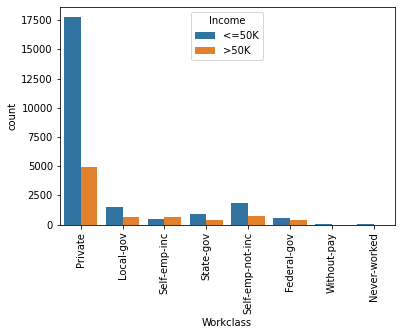

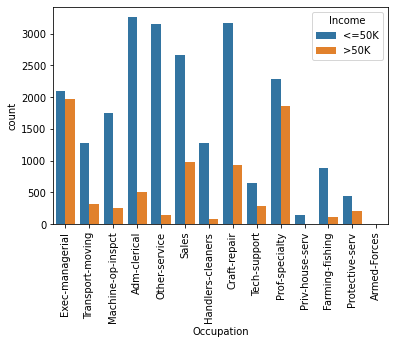

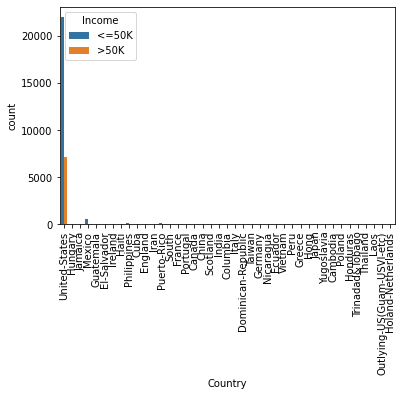

In [8]:
with_na = ['Workclass', 'Occupation', 'Country']

for col in with_na:
    graf = sns.countplot(x=col, data=df, hue='Income')
    graf.set_xticklabels(graf.get_xticklabels(), rotation=90)
    plt.show()

Podemos ver algumas discrepâncias muito boas dentre esses dados faltantes, como por exemplo em 'Country' temos quase a totalidade de dados remetendo a United-States, ou seja, talvez essa categoria, seja meio supérflua no quesito que basicamente qualquer dado que não seja pertencente a esse país seria um outlier

Também podemos ter alguns insights interessantes a respeito de 'Workclass' ainda mais pela discrepância entre pessoas com mais de 50K dependendo da categoria

In [9]:
for col in with_na:
    print('-'*15 + ' ' + col + ' ' + '-'*15)
    print()
    print(df[col].value_counts())
    print()

--------------- Workclass ---------------

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1297
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: Workclass, dtype: int64

--------------- Occupation ---------------

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3769
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: Occupation, dtype: int64

--------------- Country ---------------

United-States                 29169
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador          

Mesmo as outras tendo uma distribuição ainda um pouco pendente para um lado do que para outro, elas ainda parecem ter mais sentido que 'Country', pois isso vou apenas retirar essa coluna

In [10]:
df.drop('Country', axis=1, inplace=True)

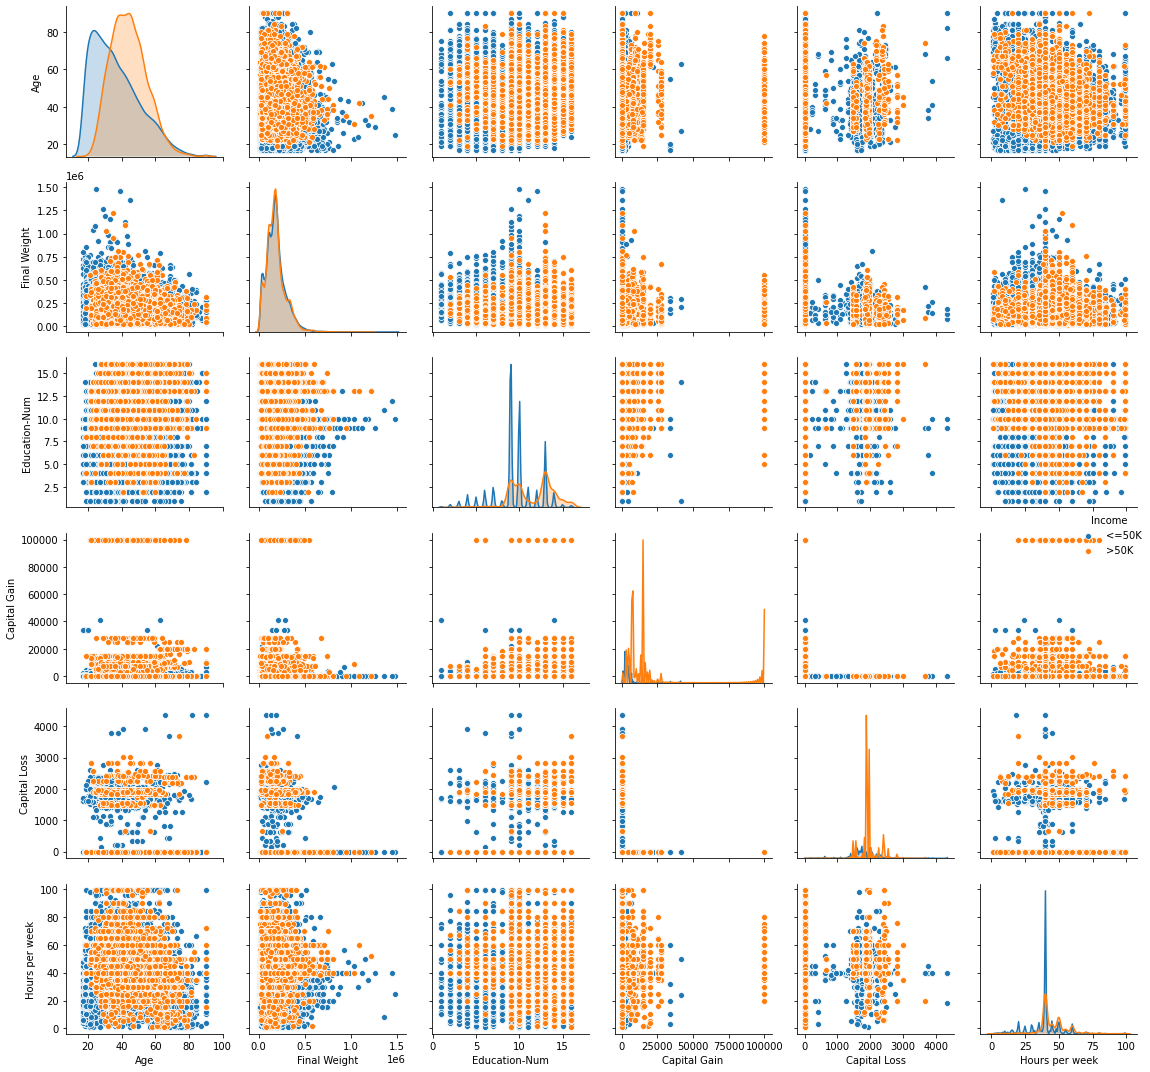

In [11]:
sns.pairplot(df, hue='Income')
plt.tight_layout()
plt.show()

Certo, vamos por partes que o pairplot é um pouco complexo, ele faz todas as combinações 2 a 2 das nossas features, nesse caso eu ainda pintei com o hue entre os dados que apresentam mais de 50K de renda com laranja e com menos de azul.

Na diagonal podemos ver a distribuição entre os dados o que mostra algumas tendências interessantes: 

*   Pessoas mais velhas tendem a ter uma maior renda
*   Final Weight não parece ser um valor determinante na renda
*   Pessoas com maior renda estão concentradas em um maior eduacational-num, mas a distribuição é semelhante com pessoas com menos renda
*   Pessoas com alto capital gain recebem mais de 50K, mas a recíproca é falsa
*   As formas de capital loss são semelhantes
*   Horas por semana é semelhante não importando sua renda



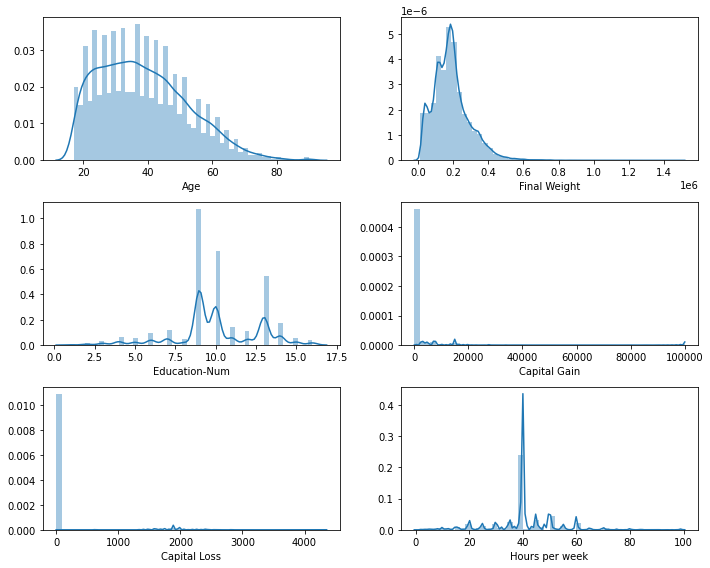

In [12]:
cols = ['Age', 'Final Weight', 'Education-Num',
        'Capital Gain', 'Capital Loss', 'Hours per week']

plt.figure(figsize=(10,8))
for i in range(len(cols)):
    plt.subplot(3, 2, i+1)
    sns.distplot(df[cols[i]])
plt.tight_layout()
plt.show()

Podemos agora dar uma olhada em algumas das distribuições das features e, quase por desencargo de consciência vamos plottar o heatmap das nossas variáveis numéricas, mas vamos ver que elas quase não tem uma relação forte entre si

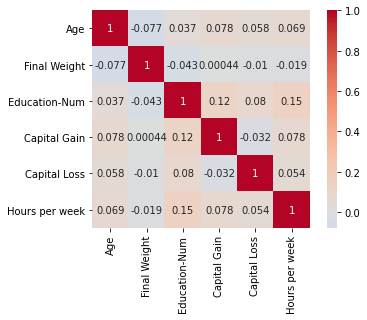

In [13]:
corr = df.corr()
sns.heatmap(corr, square=True, cmap="coolwarm", center=0, annot=True)
plt.show()

Vamos plottar e tentar analisar um pouquinhos das outras features categóricas que temos e tentar extrair alguma coisa utilizando alguns countplots

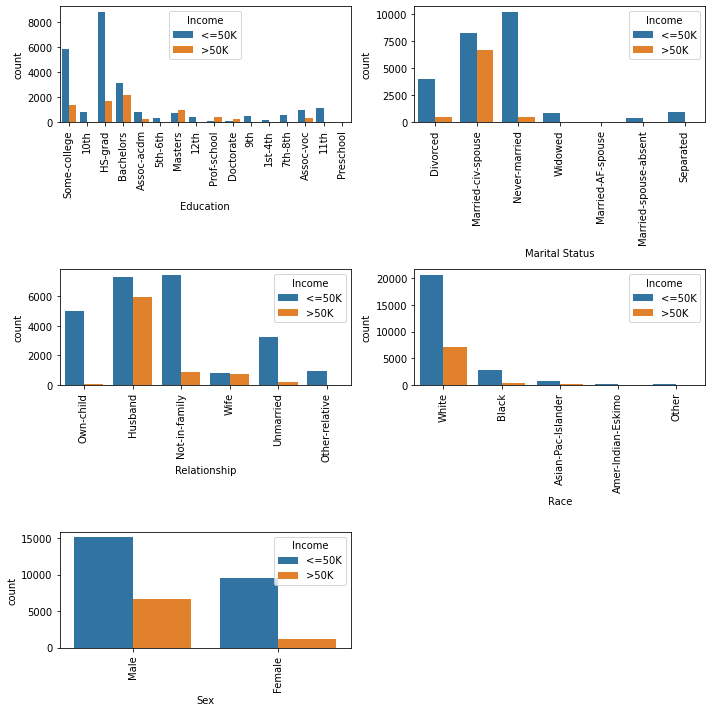

In [14]:
other_cat = ['Education', 'Marital Status', 'Relationship', 'Race', 'Sex']

plt.figure(figsize=(10,10))
for i in range(len(other_cat)):
    plt.subplot(3, 2, i+1)
    graf = sns.countplot(x=other_cat[i], data=df, hue='Income')
    graf.set_xticklabels(graf.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Acho que podemos inferir algumas coisas legais só olhando esses gráficos, muita informação fica clara quando vemos as distribuições separadas pelas rendas

* Classes como "Masters", "Prof-school" e "Doctorate" apresentam mais pessoas com renda acima de 50K, e "Bachelors" tem uma proporção significamente alte
*   "Married-civ-spouse" apresenta uma maior taxa de pessoas com renda acima de 50K
*   Pessoas com filhos tem muito poucos membros com mais de 50K, "Husband" e "Wife" apresentam taxas interessantes
*   Brancos são a grande maioria total e de pessoas com mais de 50K
*   A maioria das pessoas consultadas é Homem, e estes tem uma maior proporção de pessoas com mais de 50K
*   Podemos ver que o dataset está meio desbalanceado, cerca de 75% das observações são para pessoas com renda menor de 50K

# Pré-processamento dos dados

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

Anteriormente eu fiz uma das tarefas de pré-processamento ao retirar a coluna "Country", porém existem outras colunas redundantes e desnecessárias e o foco dessa parte é justamente deixar nossos dados prontos para serem inseridos em algum modelo.

Dessa forma teremos que lidar com dados faltantes, aplicar o One-Hot Encoder nas nossas variáveis categóricas e normalizar os dados numéricos.

Para essa parte é recomendado dar uma lida [aqui](https://medium.com/turing-talks/como-fazer-uma-limpeza-de-dados-completa-em-python-7abc9dfc19b8) um texto meu e da Vitoria sobre limpeza de dados

Para começo de conversa vou remover as colunas 'Final Weight' e 'Education', isso pelo fato que a primeira é um valor estatístico de quantas pessoas na população teriam aqueles exatos parâmetros, já o segundo é redundante com a coluna 'Education-Num'

In [16]:
df.drop(['Final Weight', 'Education'], axis=1, inplace=True)

Vamos remover nossos dados duplicados, já que a mesma observação repetidas vezes não vai nos ajudar nesse caso

In [17]:
df.drop_duplicates(keep='first', inplace=True)

Vamos conferir nossos dados faltantes agora

In [18]:
df.isna().sum()

Age                  0
Workclass         1616
Education-Num        0
Marital Status       0
Occupation        1623
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours per week       0
Income               0
dtype: int64

Podemos ver que apenas as colunas 'Workclass' e 'Occupation' apresentam dados faltantes e aparentemente existe alguma correlação, pois se uma linha tem uma dessas colunas nulas, provavelmente a outra é nula também e, mesmo essas 1623 linhas representarem um pouco mais de 5% dos dados, por simplicidade do problema vou apenas retirar essas linhas

Talvez essa não seja a abordagem mais indicada, já que poderíamos tentar imputar de alguma forma, porém como existe essa correlação entre esses dados faltantes, essas imputações podem pesar para o lado errado e não quero correr esse risco.

In [19]:
df[df['Workclass'].isnull() | df['Occupation'].isnull()]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Income
Id,,,,,,,,,,,,
16313,48,NaN,13,Married-civ-spouse,NaN,Husband,White,Male,0,0,6,<=50K
16315,30,NaN,9,Never-married,NaN,Own-child,White,Male,0,0,40,<=50K
16332,70,NaN,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,20,>50K
16340,58,NaN,8,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,<=50K
16350,67,NaN,14,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
48782,19,NaN,10,Never-married,NaN,Own-child,White,Female,594,0,10,<=50K
48797,42,NaN,10,Never-married,NaN,Not-in-family,White,Male,0,0,45,<=50K
48798,18,NaN,9,Never-married,NaN,Own-child,White,Male,0,0,60,<=50K


In [20]:
df.dropna(inplace=True)

Agora vamos já separar nossas colunas entre o tipo de variável, isso vai nos ajudar mais tarde, pois cada tipo de dato deve ter uma abordagem diferente

In [21]:
categorical = df[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex']].copy()
numerical_std = df[['Age']].copy()
numerical_MaxMin = df[['Education-Num', 'Hours per week']].copy()
sparse = df[['Capital Gain', 'Capital Loss']].copy()
target = df[['Income']].copy()

categorical.reset_index(drop=True, inplace=True)
numerical_std.reset_index(drop=True, inplace=True)
numerical_MaxMin.reset_index(drop=True, inplace=True)
sparse.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

Primeiramente vamos aplicar o OneHot Encoding com a função get_dummies do pandas, retiramos também a coluna Sex_Female, pois ela é redundante com a Sex_Male, uma vez que trata-se de uma variável binária

In [22]:
categorical = pd.get_dummies(categorical)
categorical.drop('Sex_Female', axis=1, inplace=True)

A função montar vai ajudar a gente a aglutinar os diferentes dataframes que criamos em um dataset final

In [23]:
def montar(clean, df):
    for col in df.columns:
        clean[col] = df[col]
    return clean

Para as variável 'Age' que segue uma distribuição próxima da normal o StandardScaler é mais adequado, segundo a própria documentação do Scikit-learn então vamos usá-lo

In [24]:
std = StandardScaler()
numerical_std = std.fit_transform(numerical_std)
numerical_std = pd.DataFrame({'Age' : numerical_std[:, 0]})

Outra alternativa que vou usar para 'Education-Num' e 'Hours per week' é a um normalizador de máximo mínimo já que essas distribuições são diferentes de uma normal

In [25]:
MM = MinMaxScaler()
numerical_MaxMin = MM.fit_transform(numerical_MaxMin)
numerical_MaxMin = pd.DataFrame({'Education-Num' : numerical_MaxMin[:, 0],
                                 'Hours per week' : numerical_MaxMin[:, 1]})

In [26]:
RS = RobustScaler()
sparse = RS.fit_transform(sparse)
sparse = pd.DataFrame({'Capital Gain' : sparse[:, 0],
                       'Capital Loss' : sparse[:, 1]})

In [27]:
target = pd.get_dummies(target)
target.drop('Income_<=50K', axis=1, inplace=True)
target.columns = ['Income']
y = target
y = y['Income'].to_numpy()

In [28]:
categorical.reset_index(drop=True, inplace=True)

X = pd.DataFrame()

X = montar(X, categorical)
X = montar(X, numerical_std)
X = montar(X, numerical_MaxMin)
X = montar(X, sparse)

#Aplicando na Validação

Agora vamos aplicar nossos métodos de pré-processamento nos dados de validação e deixar eles prontos para serem usados no nosso modelo.

In [29]:
val = pd.read_csv('test_data.csv', na_values='?')
ids = val['Id']
val.columns = ['Id'] + col_names[:-1]
val.drop(['Id', 'Country', 'Final Weight', 'Education'], axis=1, inplace=True)

val_cat = val[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex']].copy()
val_std = val[['Age']].copy()
val_MM = val[['Education-Num', 'Hours per week']].copy()
val_spr = val[['Capital Gain', 'Capital Loss']].copy()

val_cat.reset_index(drop=True, inplace=True)
val_std.reset_index(drop=True, inplace=True)
val_MM.reset_index(drop=True, inplace=True)
val_spr.reset_index(drop=True, inplace=True)

val_cat = pd.get_dummies(val_cat)
val_cat.drop('Sex_Female', axis=1, inplace=True)

val_std = std.transform(val_std)
val_std = pd.DataFrame({'Age' : val_std[:, 0]})

val_MM = MM.transform(val_MM)
val_MM = pd.DataFrame({'Education-Num' : val_MM[:, 0],
                       'Hours per week' : val_MM[:, 1]})

val_spr = RS.transform(val_spr)
val_spr = pd.DataFrame({'Capital Gain' : val_spr[:, 0],
                        'Capital Loss' : val_spr[:, 1]})

validation = pd.DataFrame()
validation = montar(validation, val_cat)
validation = montar(validation, val_std)
validation = montar(validation, val_MM)
validation = montar(validation, val_spr)

validation['Id'] = ids
validation.set_index('Id', inplace=True)
validation.drop('Workclass_Never-worked', axis=1, inplace=True)

# KNN

In [30]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [31]:
K = list(range(15, 36))
scores = []

for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv = 5, scoring="accuracy").mean()
    scores.append(score)

In [32]:
best_score = max(scores)
best_K = K[scores.index(best_score)]

print('A melhor acurácia foi de: ', best_score)
print('O melhor K foi: ', best_K)

A melhor acurácia foi de:  0.8568533015799081
O melhor K foi:  24


In [33]:
knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(X, y)
predictions = knn.predict(validation)

In [34]:
submission = pd.DataFrame()
submission[0] = validation.index
submission[1] = predictions
submission.columns = ['Id','Income']
submission.set_index('Id', inplace=True)

In [35]:
submission[submission['Income'] == 0] = '<=50K'
submission[submission['Income'] == 1] = '>50K'

In [36]:
submission.to_csv('submission.csv')